In [39]:
# --- IMPORTACIONES ---

# Importa librerias
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

# Importa un diccionario con fechas de campanas de terreno
from config import field_campaigns

# Importa una funcion para identificar outliers durante campanas de terreno
from piezometer_utils import identify_campaign_outliers

In [40]:
# --- CONFIGURACIONES MODIFICABLES ---

# 1. RUTA A LOS DATOS
# Busca todos los archivos que terminen en '*_cleaned.csv' en la carpeta 
# especificada y los almacena en una lista
data_path = '../../data/processed/piezometers/cleaned/'
piezometer_files = glob.glob(os.path.join(data_path, '*_cleaned.csv'))

# Imprime los archivos encontrados
print(f'Archivos con datos piezometricos encontrados: {len(piezometer_files)}')
print(piezometer_files)

# 2. FECHA DE CAMPANAS DE TERRENO
# Ver diccionario field_campaigns en archivo config.py

# 3. MAYOR INTERVALO DE MEDICION DE LOS DATALOGGERS
# Se utiliza en la funcion check_discontinuities para determinar saltos en los datos
max_expected_interval='15min'

Archivos con datos piezometricos encontrados: 6
['../../data/processed/piezometers/cleaned\\SDH1PS01_cleaned.csv', '../../data/processed/piezometers/cleaned\\SDH1PS02_cleaned.csv', '../../data/processed/piezometers/cleaned\\SDH2PP01_cleaned.csv', '../../data/processed/piezometers/cleaned\\SDH2PS01_cleaned.csv', '../../data/processed/piezometers/cleaned\\SDH2PS02_cleaned.csv', '../../data/processed/piezometers/cleaned\\SDH2PS03_cleaned.csv']


In [41]:
# --- DEFINICION DE FUNCIONES ---

# 1. IDENTIFICACION DE DATOS DUPLICADOS

def check_duplicates(df):
    """Revisa e informa sobre datos duplicados en el indice"""

    # Genera una serie booleana que almacena los indices duplicados como True
    duplicates = df.index.duplicated(keep=False)

    # Comprueba si la serie duplicates tiene algun valor True
    if not duplicates.any():
        print('\nNo hay datos duplicados')
    # De haberlos, imprime el total y a cuales registros corresponde
    else:
        print(f'\nHay {duplicates.sum()} datos duplicados:')
        print(df[duplicates])


# 2. IDENTIFICACION DE SALTOS REGULARES Y ANOMALOS EN LOS DATOS

def check_discontinuities(df, max_expected_interval):
    """Revisa e informa sobre saltos de tiempo en el indice"""
    
    # Genera una serie Timedelta que almcacena el tiempo transcurrido desde el registro anterior
    intervals = df.index.to_series().diff()

    # Genera una nueva serie con los Timedelta que superan un intervalo maximo esperado
    interval_anomalies = intervals[intervals > pd.Timedelta(max_expected_interval)]

    # Imprime los intervalos mas comunes y su frecuencia
    print(f'\nConteo de intervalos:\n{intervals.value_counts().head()}')

    # Comprueba si la serie interval_anomalies tiene algun valor
    if interval_anomalies.empty:
        print(f'\nNo hay intervalos anomalos')
    # De ser asi, imprime los registros con intervalos anomalos
    else:
        print(f'\nIntervalos anomalos:\n{interval_anomalies}')


# 3. VISUALIZACION DE DATOS ANOMALOS DURANTE CAMPANAS DE TERRENO

def check_outliers(df, campaign_dates, well_name, campaign_name):
    """Identifica, informa y visualiza outliers en un rango de fechas"""

    # Filtra el df a las fechas de la campana de terreno
    # Se usa - pd.Timedelta(seconds=1) para excluir las 00:00 hrs del dia posterior al ultimo de campaña
    df_campaign = df.loc[campaign_dates.min() : campaign_dates.max() - pd.Timedelta(seconds=1)].copy()

    # Si no hay datos durante la campana se detiene la funcion
    if df_campaign.empty:
        print("No se encontraron datos para esta campana")
        return

    # Obtiene los indices de los outliers usando la funcion importada identify_campaign_outliers
    outlier_indices = identify_campaign_outliers(df, campaign_dates)

    # Comprueba si el df_outliers tiene algun valor anomalo
    if not outlier_indices.empty:
        # Filtra el df original usando outlier_indices
        df_outliers = df.loc[outlier_indices]
        print("\nOutliers detectados:")
        print(df_outliers[['Temperature_C', 'Depth_m']])    # REVISAR ESTA LINEA
    else:
        print("\nNo se encontraron valores con z-Score > 3 en esta campana.")

    # Grafica los datos de Temperature_C y Depth_m durante la campana
    fig, ax1 = plt.subplots(figsize=(8, 4))
    # Eje izquierdo
    ax1.set_xlabel('')
    ax1.set_ylabel('Temperature (°C)')
    ax1.plot(df_campaign.index, df_campaign['Temperature_C'], color='tab:orange', label='Temperature (°C)', zorder=1)
    ax1.tick_params(axis='y')
    # Eje derecho
    ax2 = ax1.twinx()
    ax2.set_ylabel('Depth (m)')
    ax2.plot(df_campaign.index, df_campaign['Depth_m'], color='tab:blue', label='Depth (m)', zorder=1)
    ax2.tick_params(axis='y')
    ax2.invert_yaxis()
    # Outliers
    outlier_points = df_campaign.loc[outlier_indices]
    ax1.scatter(outlier_points.index, outlier_points['Temperature_C'], color='red', s=20, zorder=2)
    ax2.scatter(outlier_points.index, outlier_points['Depth_m'], color='blue', s=20, zorder=2)
    ax2.scatter([], [], color='gray', s=20, label='Outlier')
    # Leyenda
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    # Otros elementos
    plt.title(f"{well_name} - {campaign_name}")
    fig.tight_layout()
    ax1.grid(True, alpha=0.6)
    plt.show()



POZO: SDH1PS01
Archivo: SDH1PS01_cleaned.csv



Rango de fechas: 2024-05-23 00:00:00 - 2025-07-15 10:10:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35535
0 days 00:05:00    18344
0 days 00:15:00    10346
0 days 00:40:00        2
0 days 01:40:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2024-07-25 18:20:00   0 days 01:40:00
2024-09-05 14:00:00   0 days 00:40:00
2024-11-10 15:00:00   0 days 01:30:00
2025-01-22 14:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


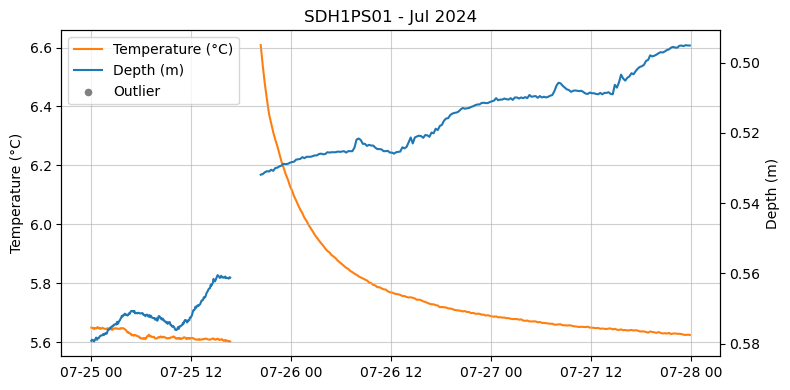


Diagnostico campana de Sep 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


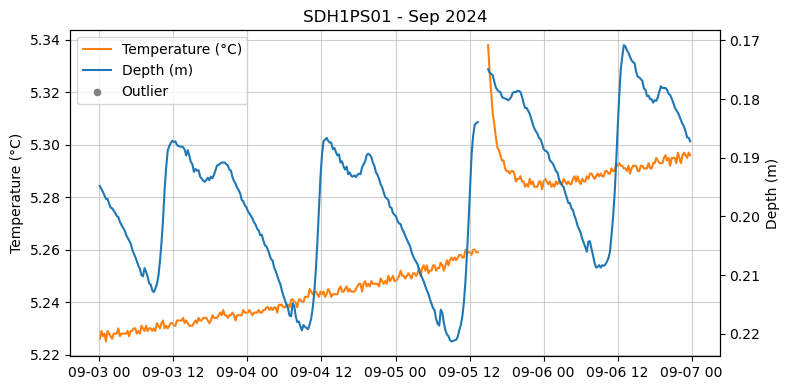


Diagnostico campana de Nov 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


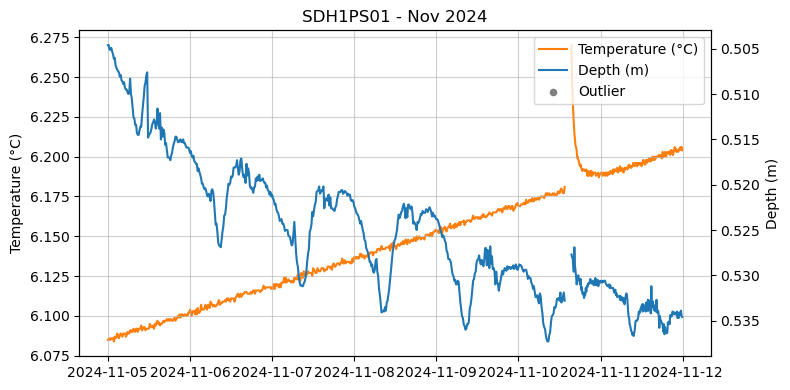


Diagnostico campana de Jan 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


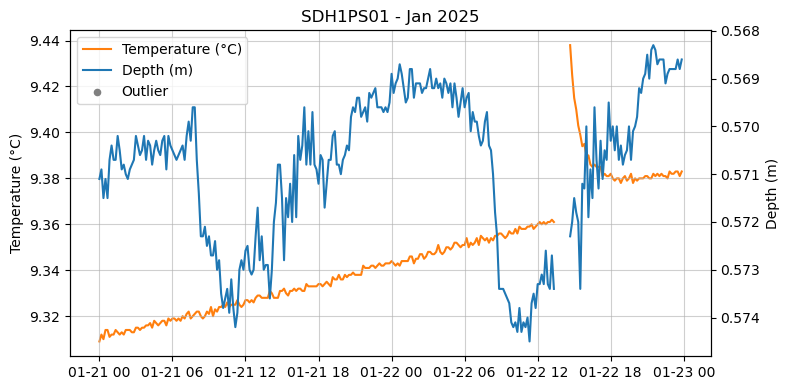


Diagnostico campana de Apr 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


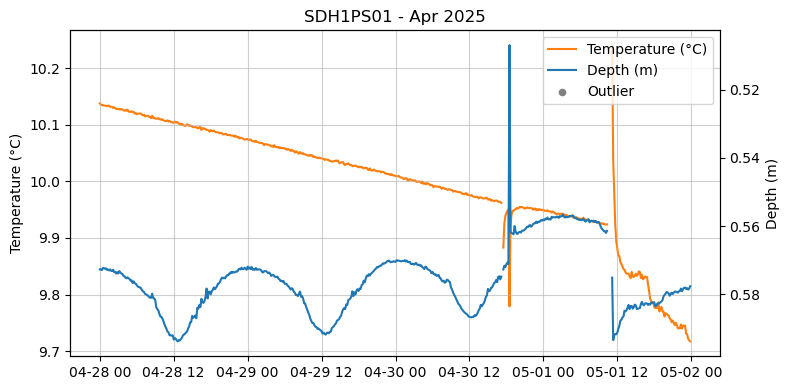


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


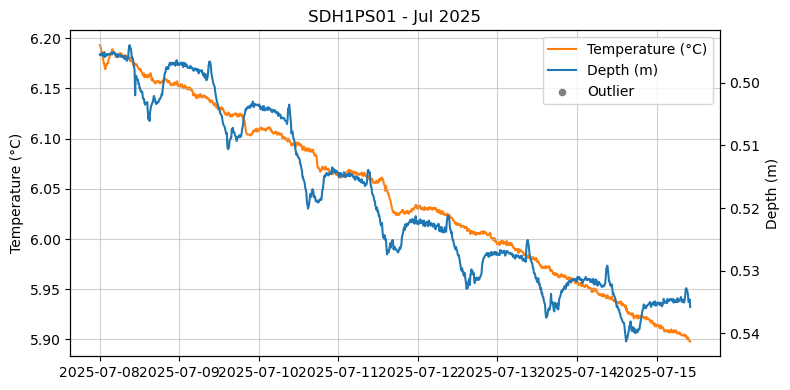


POZO: SDH1PS02
Archivo: SDH1PS02_cleaned.csv

Rango de fechas: 2024-11-10 16:00:00 - 2025-07-15 10:00:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35530
0 days 00:20:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 14:00:00   0 days 00:20:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Nov 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


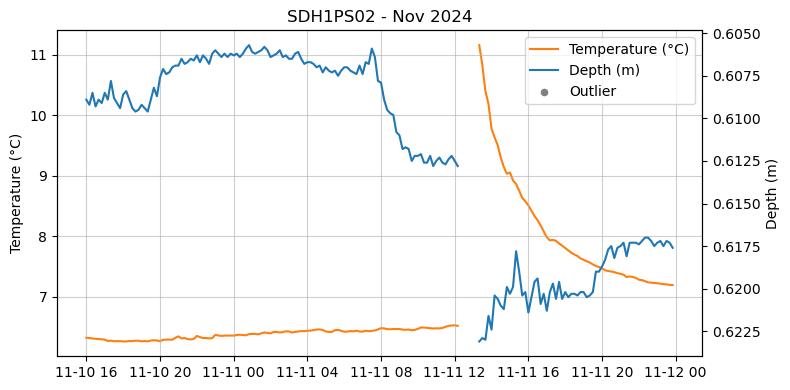


Diagnostico campana de Jan 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


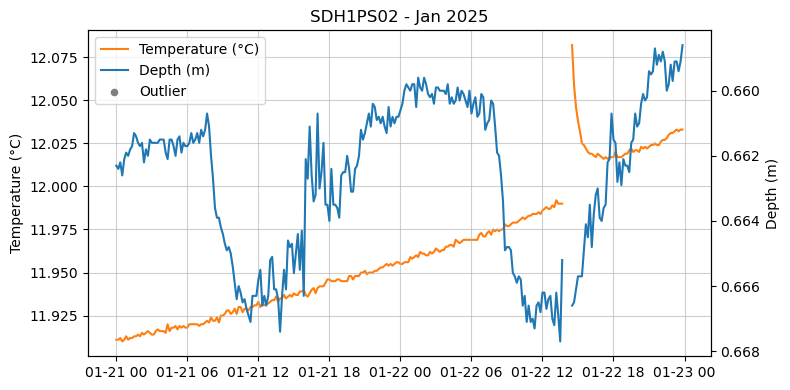


Diagnostico campana de Apr 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


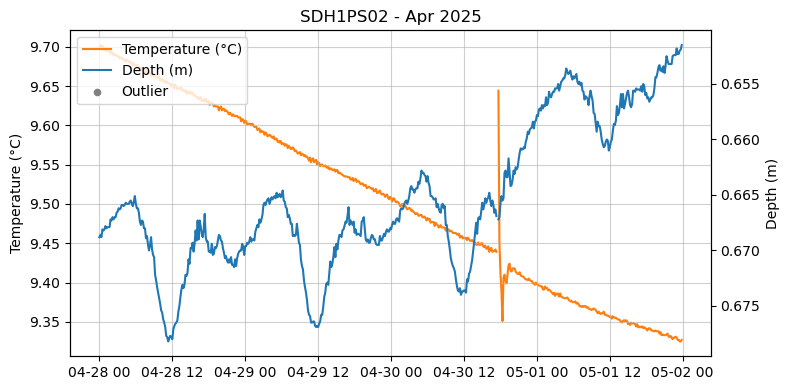


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


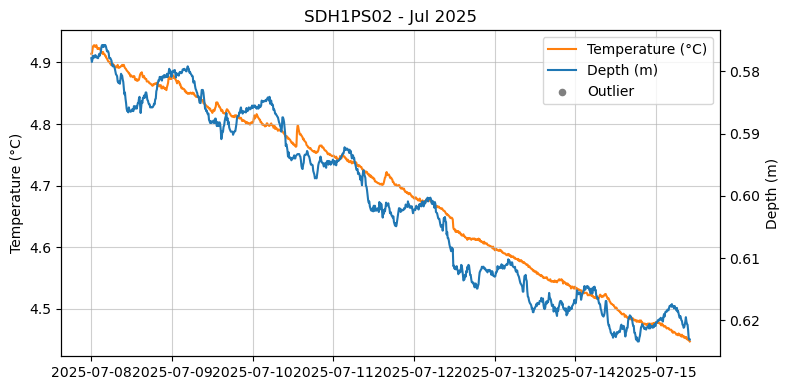


POZO: SDH2PP01
Archivo: SDH2PP01_cleaned.csv

Rango de fechas: 2024-05-24 00:00:00 - 2025-04-30 13:10:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    70160
0 days 00:10:00    14089
0 days 02:20:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 17:00:00   0 days 02:20:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


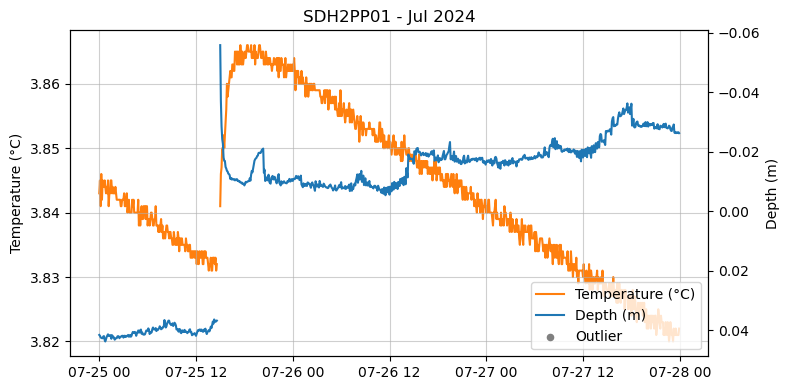


Diagnostico campana de Sep 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


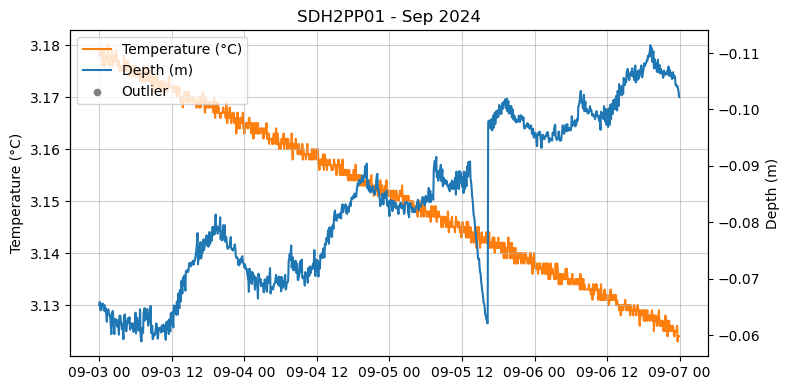


Diagnostico campana de Nov 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


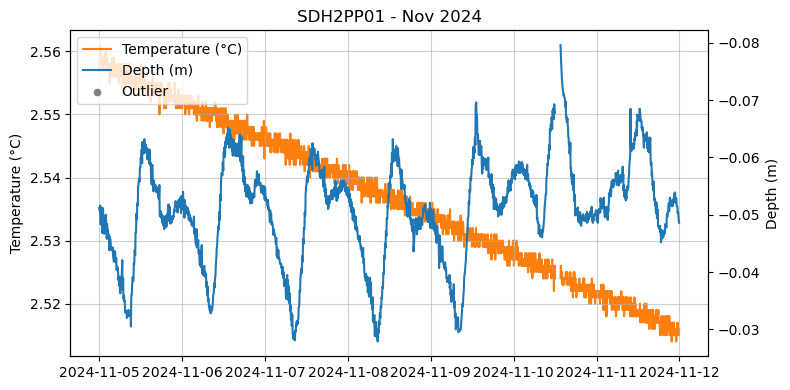


Diagnostico campana de Jan 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


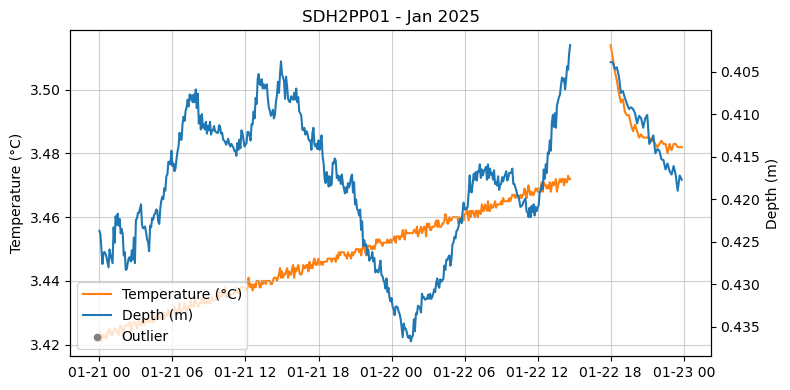


Diagnostico campana de Apr 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


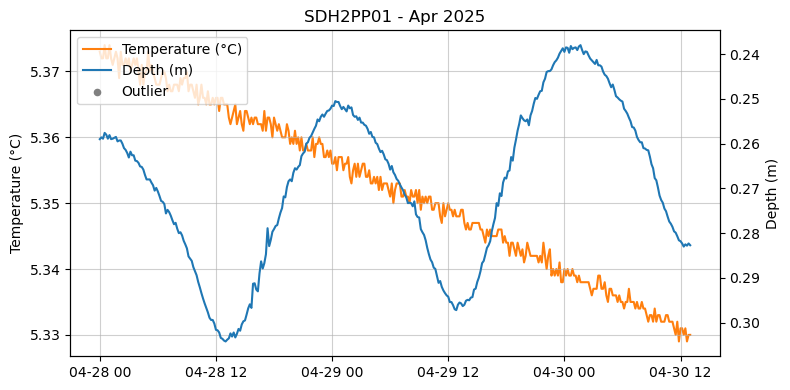


Diagnostico campana de Jul 2025
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH2PS01
Archivo: SDH2PS01_cleaned.csv

Rango de fechas: 2024-05-23 00:00:00 - 2024-11-08 16:25:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    48291
1 days 00:05:00        2
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2024-07-26   1 days 00:05:00
2024-09-06   1 days 00:05:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


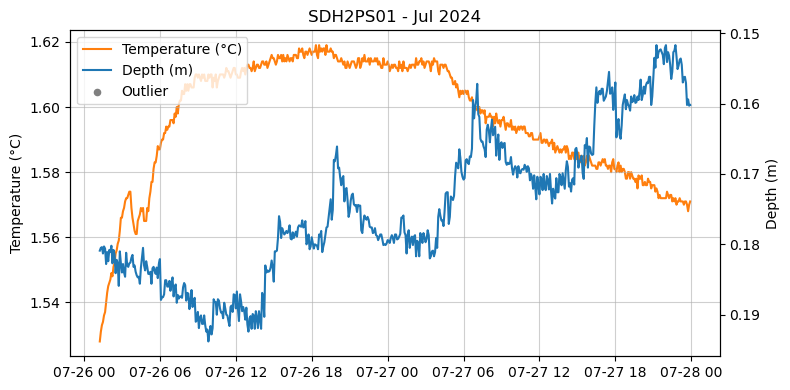


Diagnostico campana de Sep 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


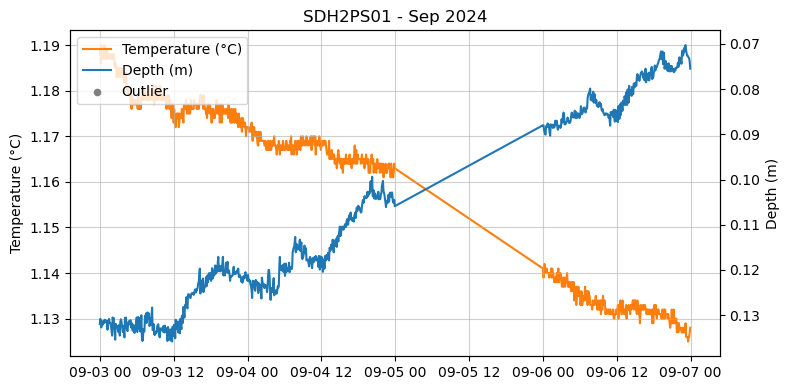


Diagnostico campana de Nov 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


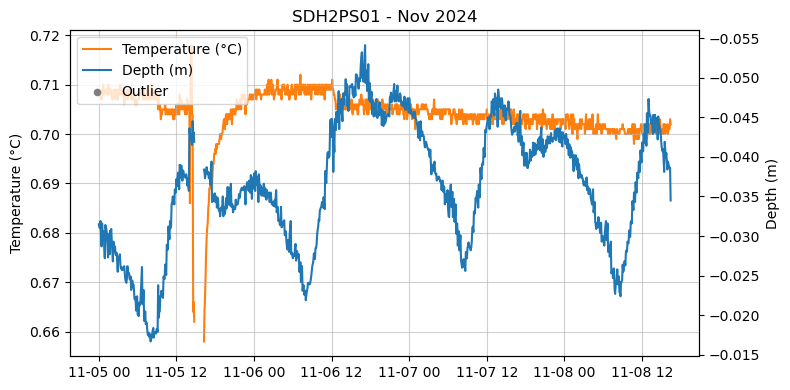


Diagnostico campana de Jan 2025
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Apr 2025
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2025
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH2PS02
Archivo: SDH2PS02_cleaned.csv

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:40:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35520
0 days 00:40:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 16:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diag

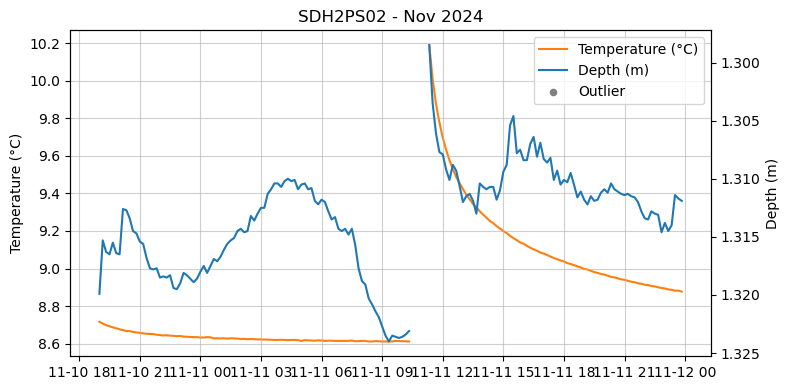


Diagnostico campana de Jan 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


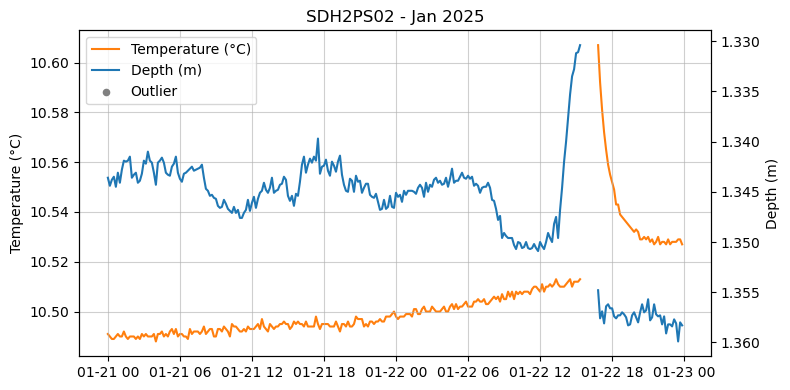


Diagnostico campana de Apr 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


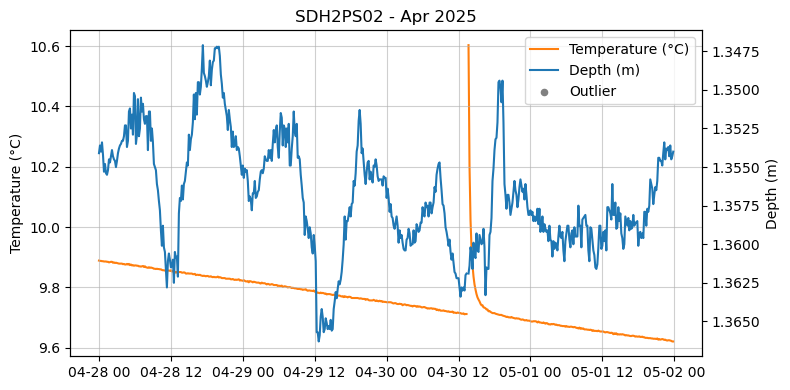


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


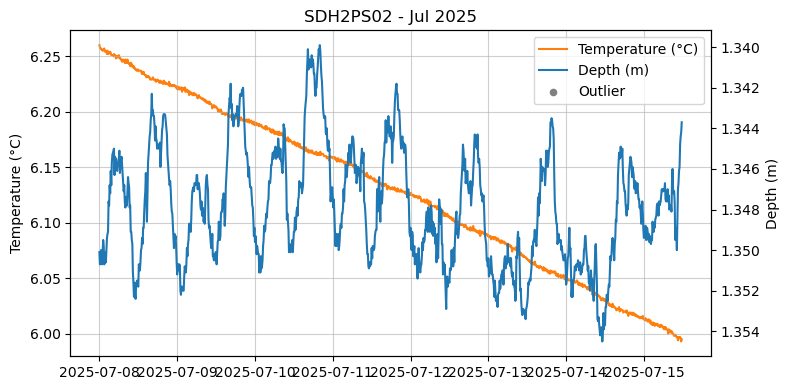


POZO: SDH2PS03
Archivo: SDH2PS03_cleaned.csv

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:50:00

--- Diagnostico de datos ---

No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35522
0 days 00:30:00        1
Name: count, dtype: int64

Intervalos anomalos:
Timestamps
2025-01-22 16:00:00   0 days 00:30:00
Name: Timestamps, dtype: timedelta64[ns]

Diagnostico campana de May 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Jul 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Sep 2024
Identificacion de outliers
No se encontraron datos para esta campana

Diagnostico campana de Nov 2024
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


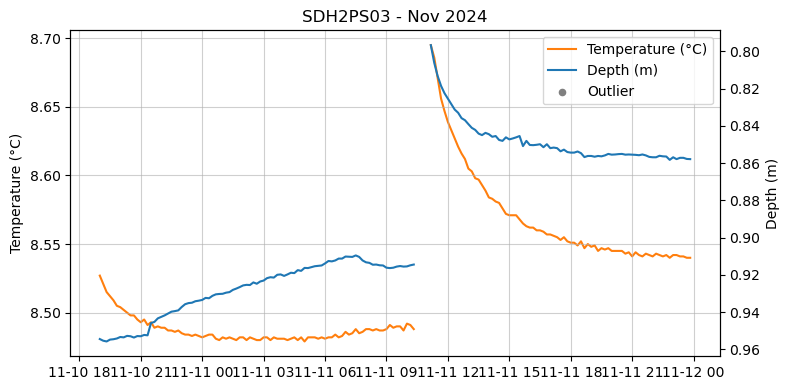


Diagnostico campana de Jan 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


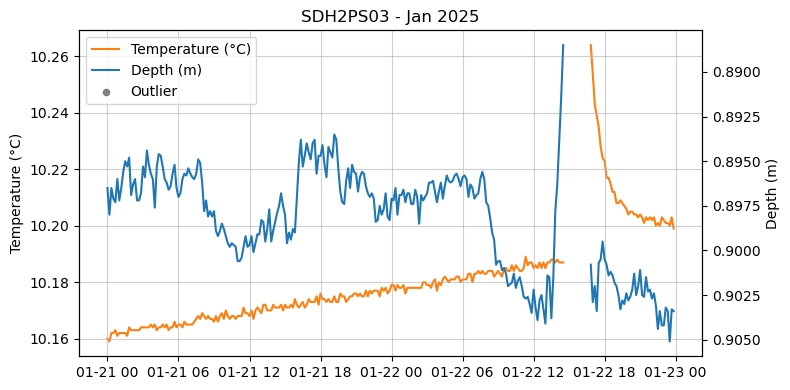


Diagnostico campana de Apr 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


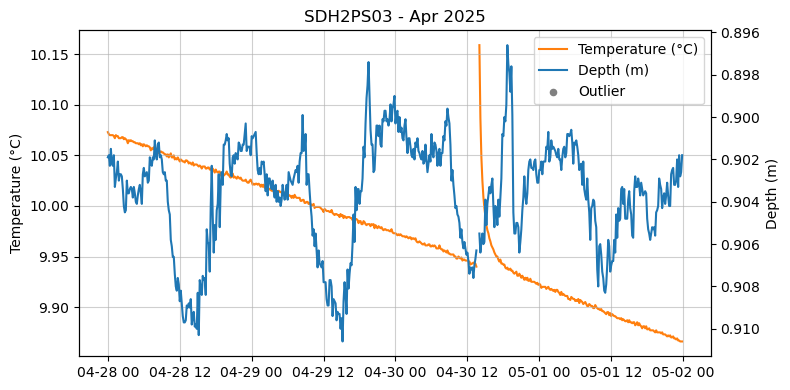


Diagnostico campana de Jul 2025
Identificacion de outliers

No se encontraron valores con z-Score > 3 en esta campana.


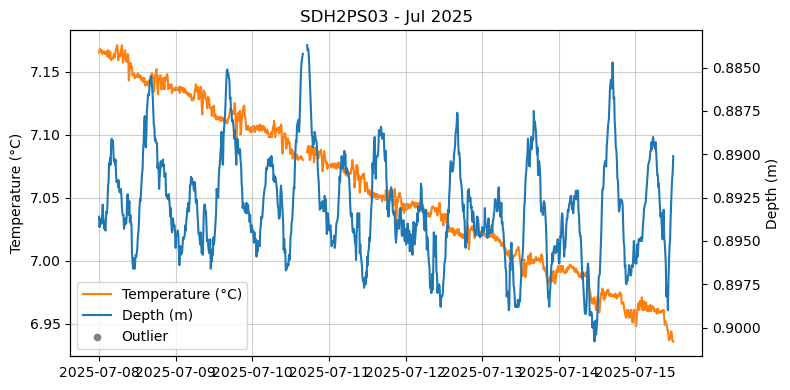

In [42]:
# --- BUCLE DE PROCESAMIENTO ---

# Bucle externo: itera sobre cada pozo
# file_path refiere a cada valor de la lista piezometer_files
for file_path in piezometer_files:
    
    # Define el nombre de cada pozo usando el nombre de archivo.
    # Mantiene la primera cadena de texto, separadas por guion bajo
    base_name = os.path.basename(file_path)
    well_name = base_name.split('_')[0].strip()
    
    # Imprime un titulo que indica el nombre del pozo y de archivo
    print("\n" + "="*80)
    print(f"POZO: {well_name}")
    print(f"Archivo: {os.path.basename(file_path)}")
    print("="*80)
   
   # Lee los datos formateados e imprime el rango de fechas
    df_formatted = pd.read_csv(file_path, index_col='Timestamps', parse_dates=True)
    print(f"\nRango de fechas: {df_formatted.index.min()} - {df_formatted.index.max()}")

    # Aplica las funciones de diagnostico de datos aplicables a todo el archivo
    print("\n--- Diagnostico de datos ---")
    check_duplicates(df_formatted)
    check_discontinuities(df_formatted, max_expected_interval)

    # Bucle interno: itera sobre las campanas de terreno. 
    # name y dates refieren a los pares de valores almacenados en el diccionario field_campaigns
    for campaing_name, campaign_dates in field_campaigns.items():

        # Imprime el nombre de la campana
        print(f"\nDiagnostico campana de {campaing_name}")

        # Aplica la funcion de identificacion de outliers
        print("Identificacion de outliers")
        check_outliers(df_formatted, campaign_dates, well_name, campaing_name)